# 05_plot_the_results

In [1]:
from pigeon_feather.data import *
from pigeon_feather.plot import *
from pigeon_feather.hxio import *
from pigeon_feather.spectra import *


import numpy as np
import pandas as pd

import datetime
import os
import pickle
import datetime

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


In [2]:
# load the pickle file we saved in the previous notebook


today = datetime.date.today().strftime("%Y%m%d")
today = "20240722"

with open(f"./data/hdxms_data_raw_{today}.pkl", "rb") as f:
    hdxms_data_list = pickle.load(f)


# back exchange correction for peptides with experimental full deuteration data based its closest match in the database
tools.backexchange_correction(hdxms_data_list)

Number of peptides with experimental max_d: 358
Number of peptides with no experimental max_d: 12


In [3]:
# make folders for results

today_date = datetime.date.today().strftime("%Y%m%d")
# today_date = '20240722'
results_path = f"ecDHFR_results_{today_date}"

if not os.path.exists(results_path):
    os.makedirs(results_path)


out_path = "./data/PF_input_20240722"

Create an `Analysis` object and load the results. **Note:** The temperature and pH are crucial for calculating the intrinsic exchange rates, so make sure to input the correct values. The chunk size and chunk number can be altered by the user. In this tutorial, they were automatically determined by a helper function.


In [4]:
from pigeon_feather.analysis import Analysis, get_index_offset
from pigeon_feather.tools import optimal_chunks
import matplotlib.pyplot as plt

RUN_NUM = 3

apo_states = [
    state
    for data in hdxms_data_list
    for state in data.states
    if state.state_name == "APO"
]

tri_states = [
    state
    for data in hdxms_data_list
    for state in data.states
    if state.state_name == "TRI"
]

ana_apo_1 = Analysis(apo_states, temperature=293.0, pH=7.0)

chunk_num, chunk_size = optimal_chunks(len(ana_apo_1.protein_sequence))
ana_apo_1.load_bayesian_hdx_oupt_chunks(
    chunk_size=chunk_size,
    chunk_num=chunk_num,
    state_name="APO",
    run_num=RUN_NUM,
    N=200,
    bayesian_hdx_data_folder=f"{out_path}/bayesian_hdx_output_chunks",
)


ana_tri_1 = Analysis(tri_states, temperature=293.0, pH=7.0)

ana_tri_1.load_bayesian_hdx_oupt_chunks(
    chunk_size=chunk_size,
    chunk_num=chunk_num,
    state_name="TRI",
    run_num=RUN_NUM,
    N=200,
    bayesian_hdx_data_folder=f"{out_path}/bayesian_hdx_output_chunks",
)

## barplot of the kex

barplot showing the FEATHER derived exchange rates. index_offset is determined by comparison to the sequence in HX/MS and the pdb file provided.

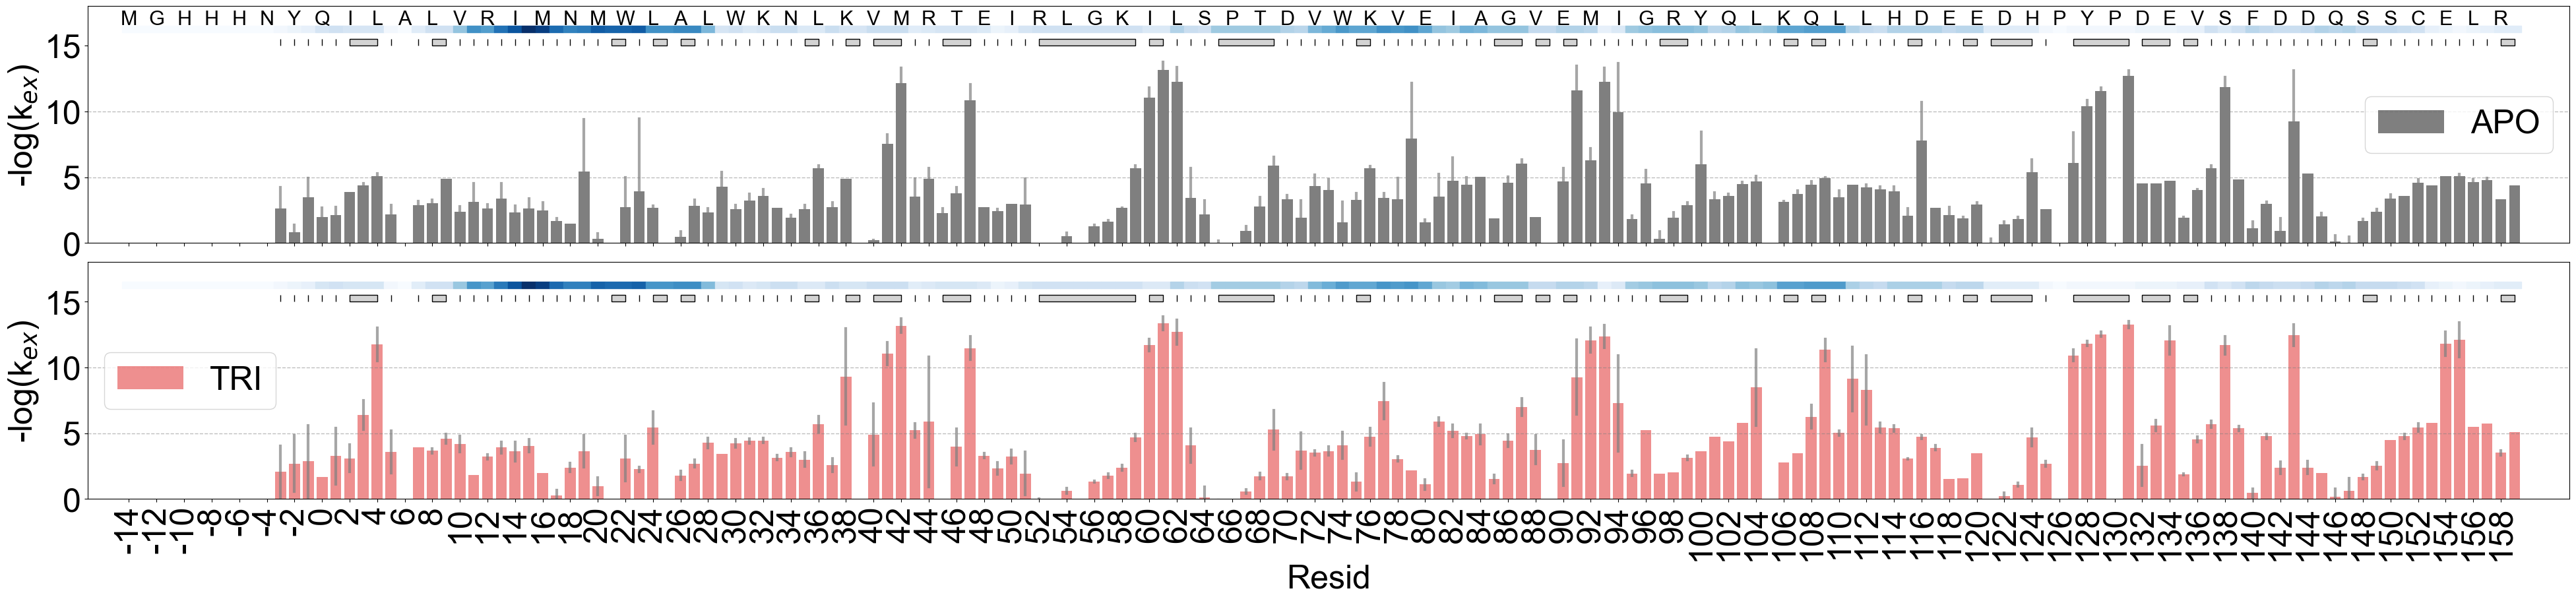

In [5]:
# APO state only

import numpy as np


fig, axes = plt.subplots(2, 1, figsize=(40, 10), sharey=True, sharex=True)

ana_apo_1.plot_kex_bar(
    ax=axes[0], resolution_indicator_pos=15, label="APO", show_seq=False, color="k"
)

ana_tri_1.plot_kex_bar(
    ax=axes[1], resolution_indicator_pos=15, label="TRI", show_seq=False, color="red"
)

from matplotlib.pyplot import step
from matplotlib.ticker import FuncFormatter, MultipleLocator

from pigeon_feather.analysis import get_index_offset

pdb_file = "./data/6XG5_TRI.pdb"
index_offset = get_index_offset(ana_apo_1, pdb_file)

# # ax.xaxis.set_major_locator(plt.MultipleLocator(2))
axes[0].set_xticks(axes[0].get_xticks()[::2])
axes[0].set_xticklabels(axes[0].get_xticklabels(), fontdict={"fontsize": 24})


def format_func(value, tick_number):
    return f"{int(value - index_offset +1)}"


axes[0].xaxis.set_major_formatter(FuncFormatter(format_func))

seq_pos = 17
for ii in range(0, len(ana_apo_1.protein_sequence[:]), 2):
    axes[0].text(
        ii,
        seq_pos,
        ana_apo_1.protein_sequence[ii],
        ha="center",
        va="center",
        fontsize=22,
    )


for ax in axes:
    ax.set_ylabel("-log(k$_{ex}$)")
    #ax.legend(loc="lower left")
    ax.yaxis.set_major_locator(plt.MultipleLocator(5))

    ax.plot(
        [-3, len(ana_apo_1.protein_sequence) + 3],
        [5, 5],
        color="gray",
        lw=1,
        linestyle="--",
        alpha=0.5,
    )
    ax.plot(
        [-3, len(ana_apo_1.protein_sequence) + 3],
        [10, 10],
        color="gray",
        lw=1,
        linestyle="--",
        alpha=0.5,
    )


plt.subplots_adjust(hspace=0.08)
fig.savefig(f"{results_path}/ecDHFR_kex_bar_APO_TRI_{today_date}.pdf")

logP projection to a pdb structure

In [6]:
from pigeon_feather.analysis import BFactorPlot

In [7]:
bfactor_plot = BFactorPlot(
    ana_apo_1,
    pdb_file="./data/6XG5_TRI.pdb",
    plot_deltaG=True,
    temperature=293.15,
    logP_threshold=10,
)
bfactor_plot.plot(f"{results_path}/6XG5_APO_deltaG.pdb")

# bfactor_plot = BFactorPlot(
#     ana_apo_1,
#     pdb_file="./data/6XG5_APO_relaxed_best_solvated.pdb",
#     plot_deltaG=True,
#     temperature=293.15,
# )
# bfactor_plot.plot(f"{out_path}/6XG5_APO_deltaG.pdb")

## delta log(PF)s

if there are mutiple states availble, you can map the difference to the pdb strutcure

In [8]:
bfactor_plot = BFactorPlot(
    ana_apo_1,
    ana_tri_1,  
    pdb_file="./data/6XG5_TRI.pdb",
    plot_deltaG=True,
    temperature=293.15,
    logP_threshold=10,
)
bfactor_plot.plot(f"{results_path}/6XG5_deltaG_APO-TRI.pdb")

You can visualize the results in PyMOL by running the following commands:

```bash
spectrum b, green_white_magenta, minimum=-20, maximum=20; select nans, not (b=0 or b>0 or b<0); color grey20, nans;
```

`nans` are Prolines and residues with no coverage.

export logPFs to a csv

In [9]:
import MDAnalysis
from pigeon_feather.analysis import get_res_avg_logP, get_res_avg_logP_std

pdb_file = "./data/6XG5_TRI.pdb"
index_offset = get_index_offset(ana_apo_1, pdb_file)


def logPF_to_deltaG(ana_obj, logPF):
    """
    :param logPF: logP value
    :return: deltaG in kJ/mol, local unfolding energy
    """

    return 8.3145 * ana_obj.temperature * np.log(10) * logPF / 1000


def create_logP_df(ana_obj, index_offset):
    df_logPF = pd.DataFrame()

    for res_i, _ in enumerate(ana_obj.results_obj.protein_sequence):
        res_obj_i = ana_obj.results_obj.get_residue_by_resindex(res_i)

        avg_logP, std_logP = get_res_avg_logP(res_obj_i)
        #std_logP = get_res_avg_logP_std(res_obj_i)

        df_i = pd.DataFrame(
            {
                "resid": [res_obj_i.resid - index_offset],
                #"resname": [res_obj_i.resname],
                "resname": [MDAnalysis.lib.util.convert_aa_code(res_obj_i.resname)],
                'avg_dG': [logPF_to_deltaG(ana_obj, avg_logP)],
                'std_dG': [logPF_to_deltaG(ana_obj, std_logP)],
                "avg_logP": [avg_logP],
                "std_logP": [max(std_logP, 0.35)],
                "is_nan": [res_obj_i.is_nan()],
            }
        )

        if res_obj_i.is_nan():
            df_i["single resloved"] = [np.nan]
            df_i["min_pep logPs"] = [np.nan]

        else:
            df_i["single resloved"] = [res_obj_i.mini_pep.if_single_residue()]
            df_i["min_pep logPs"] = [res_obj_i.clustering_results_logP]

        df_logPF = pd.concat([df_logPF, df_i])

    df_logPF = df_logPF.reset_index(drop=True)

    return df_logPF


df = create_logP_df(ana_apo_1, index_offset)
df.to_csv(f"{results_path}/logP_APO_{today_date}.csv", index=False)


In [10]:
# fecth two df and merge
df_apo = create_logP_df(ana_apo_1, index_offset)
df_tri = create_logP_df(ana_tri_1, index_offset)

df = pd.merge(df_apo, df_tri, on="resid", suffixes=("_APO", "_TRI"))

df.to_csv(f"{results_path}/logP_APO_TRI_{today_date}.csv", index=False)